In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# 1. 학습

## 라이브러리 임포트

In [2]:
import os
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import random

import math
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torch.autograd import Variable

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import cv2
from IPython.display import display
from PIL import Image

from dataclasses import dataclass, field
from typing import Tuple, List

import warnings
warnings.filterwarnings('ignore')

from enum import Enum

import joblib
import shap
from sklearn.utils import resample

class ModelType(Enum):
  BEST = "best"
  LAST = "last"

class DataType(Enum):
  TRAIN = "train"
  VAL = "val"
  TEST = "test"

base_dir = "/content/drive/MyDrive/DMS"


## 1-2. LSTM Input 형식으로 변환

### Config 설정

In [3]:
from dataclasses import dataclass

@dataclass
class Config:
    case_name: str = "bi-lstm_attention_ensemble_24f/optuna/folds_adamw_prune" # 바꿔야하는 부분

    # 모델 구조
    lstm_num_layers: int = 3
    lstm_hidden_size: int = 512
    fc_hidden_size: int = 256
    dropout_rate: float = 0.2 # input-to-hidden (between layers)
    bidirectional: bool = True

    # 학습 설정
    batch_size: int = 32
    epochs: int = 100
    learning_rate: float = 3e-4
    optimizer: str = "adam" # or "sgd", "adamw"

    # 입력 데이터(수정한 부분)
    sequence_length: int = 24
    sliding_window_step: int = 24 # sliding window 사용 x -> seuqnce_length와 같은 값으로 설정
    features: list = field(default_factory=lambda: ["mar", "ear", "yaw", "pitch", "phone_detected"])
    labels: list = field(default_factory=lambda: ["normal", "phonecall", "text", "yawn"])

    apply_yaw_inversion: bool = False
    apply_noise_jittering: bool = False

    # 학습 제어 - 조기 종료 / 러닝레이트 스케줄러
    use_early_stopping: bool = False  # 조기 종료 사용 여부
    use_lr_scheduler: bool = False    # 학습률 스케줄러 사용 여부
    early_stopping_patience: int = 20 # early stopping 기준 epoch
    reduce_lr_factor: float = 0.5 # learning rate 감소 비율
    reduce_lr_patience: int = 7 # learning rate 감소 기준 epoch

    # 랜덤시드 설정
    random_seed: int = 24

    def __post_init__(self):
      self.results_save_path = f"{base_dir}/runs/{self.case_name}"
      self.model_save_path = f"{self.results_save_path}/weights"

      os.makedirs(self.results_save_path, exist_ok=True)
      os.makedirs(self.model_save_path, exist_ok=True)

      if self.sequence_length == 12:
        df_path = f'{base_dir}/data/splits/12frame_windows'
        self.group_col = 'groups_12'
      elif self.sequence_length == 24:
        df_path = f'{base_dir}/data/splits/24frame_windows'
        self.group_col = 'groups_24'

      self.train = pd.read_csv(os.path.join(df_path, "final_train.csv"))
      self.validation = pd.read_csv(os.path.join(df_path, "final_val.csv"))
      self.test = pd.read_csv(os.path.join(df_path, "final_test.csv"))

      # label_mapping
      self.label_encoding = {}
      self.label_decoding = {}
      for i, label in enumerate(self.labels):
          self.label_encoding[label] = i # 문자열 라벨 : 숫자 인덱스
          self.label_decoding[i] = label # 숫자 인덱스 : 문자열 라벨

      # 디바이스 설정
      self.use_cuda = torch.cuda.is_available()
      self.device = torch.device("cuda" if self.use_cuda else "cpu")

cfg = Config()
# print(cfg.case_name) # 사용 예시

In [4]:
def set_random_seed(seed):
    torch.manual_seed(seed)  # PyTorch CPU 연산에 대한 시드 설정
    torch.cuda.manual_seed(seed)  # CUDA 연산에 대한 시드 설정 (GPU 사용 시)
    torch.cuda.manual_seed_all(seed)  # 여러 GPU를 사용하는 경우 모든 GPU에 동일한 시드 설정
    np.random.seed(seed)  # NumPy 연산에 대한 시드 설정
    random.seed(seed)  # Python 기본 random 모듈의 시드 설정
    torch.backends.cudnn.deterministic = True  # CuDNN 연산의 결정론적 동작 보장
    torch.backends.cudnn.benchmark = False  # 성능 최적화 비활성화 (재현성 보장)

set_random_seed(cfg.random_seed)

### 데이터 로드

### train, val, test 데이터셋 로드

In [5]:
train_df = cfg.train.copy()
val_df = cfg.validation.copy()
test_df = cfg.test.copy()

In [6]:
# train normal undersampling
train_df = train_df[((train_df['label'] == 'normal') &
                    (train_df[cfg.group_col].isin([1, 2]))) | # sequence_length에 따라 group_col이 설정됨 -> 파일 로드 -> group_col로 정의된 groups_12 열 가져오기
                    (train_df['label'] != 'normal')]

### generate_sequence_dataset

In [7]:
def generate_sequence_dataset(
    df: pd.DataFrame
) -> Tuple[np.ndarray, np.ndarray, List[Tuple]]: # 가독성을 위해 변환 타입 명시. 작동x
    sequences, labels, metadata = [], [], []

    for (label, clip_id), clip_df in df.groupby(['label', 'clip_id']):
        clip_df = clip_df.sort_values('frame_no')
        frame_values = clip_df[cfg.features].values #(프레임 수, 변수 수)

        if len(frame_values) < cfg.sequence_length:
            continue

        for i in range(0, len(frame_values) - cfg.sequence_length + 1, cfg.sliding_window_step): # 전체 120, 슬라이딩 윈도우 12라면 (0, 109, 12)로 잘 들어간다
            seq = frame_values[i:i + cfg.sequence_length]
            if seq.shape[0] == cfg.sequence_length:
                sequences.append(seq)
                labels.append(cfg.label_encoding[label])
                # 학습 후 오분류 데이터 확인을 위한 시작 프레임 번호 저장
                metadata.append((label, clip_id, clip_df.iloc[i]['frame_no']))

    return TensorDataset(torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)), metadata

### DataLoader

In [8]:
train_params = {
    "batch_size": cfg.batch_size,
    "shuffle": True,
    "num_workers": 4,
    "pin_memory": cfg.use_cuda,
    "persistent_workers": cfg.use_cuda,
    "prefetch_factor": 2 if cfg.use_cuda else None,
}

test_params = {
    "batch_size": cfg.batch_size,
    "shuffle": False,
    "num_workers": 0,
    "pin_memory": cfg.use_cuda
}

In [9]:
# DataLoader 생성 (배치 단위로 데이터를 나누기 위해 사용)
train_dataset, train_metadata = generate_sequence_dataset(train_df)
val_dataset, val_metadata = generate_sequence_dataset(val_df)
test_dataset, test_metadata = generate_sequence_dataset(test_df)

train_loader = DataLoader(train_dataset, **train_params)
val_loader = DataLoader(val_dataset, **test_params)
test_loader = DataLoader(test_dataset, **test_params)

# 배치 단위 확인
for x_batch, y_batch in train_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

for x_batch, y_batch in val_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

for x_batch, y_batch in test_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

Batch Shape: torch.Size([32, 24, 5]) torch.Size([32])
Batch Shape: torch.Size([32, 24, 5]) torch.Size([32])
Batch Shape: torch.Size([32, 24, 5]) torch.Size([32])


## 1-3. 모델 로드

### 모델 준비 함수

In [10]:
# 모델 준비
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, hidden_dim)
        self.context = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        # lstm_output: [B, T, H]
        score = torch.tanh(self.attn(lstm_output))         # [B, T, H]
        attn_weights = torch.softmax(self.context(score), dim=1)  # [B, T, 1]
        attended_output = torch.sum(attn_weights * lstm_output, dim=1)  # [B, H]
        return attended_output, attn_weights  # context vector, weights

In [11]:
# LSTM 모델 정의
class DecoderRNN(nn.Module):
    def __init__(self, lstm_hidden_size, fc_hidden_size, dropout_rate):
        super(DecoderRNN, self).__init__()

        self.RNN_input_size = len(cfg.features)
        self.h_RNN_layers = cfg.lstm_num_layers
        self.h_RNN = lstm_hidden_size
        self.h_FC_dim = fc_hidden_size
        self.drop_p = dropout_rate
        self.num_classes = len(cfg.labels)
        self.bidirectional = cfg.bidirectional

        self.LSTM = nn.LSTM(
            input_size=self.RNN_input_size,
            hidden_size=self.h_RNN,
            num_layers=self.h_RNN_layers,
            batch_first=True,
            bidirectional=self.bidirectional
        )

        lstm_output_dim = self.h_RNN * (2 if self.bidirectional else 1)

        self.attention = Attention(lstm_output_dim) # Attention 추가
        self.fc1 = nn.Linear(lstm_output_dim, self.h_FC_dim)
        self.bn1 = nn.BatchNorm1d(self.h_FC_dim)  # Batch Normalization 추가
        self.fc2 = nn.Linear(self.h_FC_dim, self.num_classes)
        self.dropout = nn.Dropout(p=self.drop_p)

    def forward(self, x_RNN):
        self.LSTM.flatten_parameters()
        out, _ = self.LSTM(x_RNN)  # (batch, seq_len, hidden*2)

        attn_out, attn_weights = self.attention(out)  # attn_out: [B, H]

        # FC layers
        x = self.fc1(attn_out)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x, attn_weights  # CrossEntropyLoss 사용 (Softmax 없음), attn_weights 함께 반환

### 모델 로드 함수

In [12]:
# 모델 로드 함수
def load_model(model, device, model_type=ModelType.BEST):
    """저장된 모델을 불러오는 함수"""
    model_path = os.path.join(cfg.model_save_path, f"{model_type.value}_model.pth")
    checkpoint = torch.load(model_path, map_location=device)
    #torch.save로 저장된 모델은 모델 가중치만 저장되어 있어 미리 모델 구조를 정의해줘야 한다
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()
    print(f"✅ Model Loaded from {model_path}")
    return model

### 예측값 출력 함수

In [13]:
def get_preds_and_labels_ensemble(models: List[torch.nn.Module], device, data_loader, print_sample=False, max_print=10):
    """
    앙상블 모델을 이용한 예측 결과 및 입력/출력 정보 반환
    """
    for model in models:
        model.eval()

    all_inputs = []
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # 각 모델에 대해 softmax 확률 계산
            ensemble_probs = []
            for model in models:
                logits = model(x_batch)
                if isinstance(logits, tuple):
                    logits = logits[0]
                probs = F.softmax(logits, dim=1)
                ensemble_probs.append(probs)

            # 확률 평균
            avg_probs = torch.stack(ensemble_probs).mean(dim=0)
            preds = torch.argmax(avg_probs, dim=1)

            all_inputs.extend(x_batch.cpu())
            all_labels.extend(y_batch.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(avg_probs.cpu().numpy())

    # 옵션: 일부 샘플 출력
    if print_sample:
        print("=== Sample Predictions ===")
        for i in range(min(max_print, len(all_labels))):
            print(f"[{i}] True: {all_labels[i]} | Pred: {all_preds[i]} | Prob: {all_probs[i]}")

    return (
        torch.stack(all_inputs),          # shape: [N, T, F]
        np.array(all_labels),             # shape: [N]
        np.array(all_preds),              # shape: [N]
        np.array(all_probs),              # shape: [N, num_classes]
    )


### 실행

In [14]:
import glob

def load_all_best_models(lstm_hidden_size, fc_hidden_size, dropout_rate, device) -> List[torch.nn.Module]:
    """폴더 내 모든 best_model_*.pth 파일을 불러와 모델 리스트 반환"""
    model_list = []
    pattern = os.path.join(cfg.model_save_path, "best_model_*.pth")
    model_paths = sorted(glob.glob(pattern))

    for path in model_paths:
        model = DecoderRNN(lstm_hidden_size, fc_hidden_size, dropout_rate).to(device)
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        model.eval()
        model_list.append(model)
        print(f"✅ Loaded: {os.path.basename(path)}")

    return model_list

In [15]:
models = load_all_best_models(cfg.lstm_hidden_size, cfg.fc_hidden_size, cfg.dropout_rate, cfg.device) # best model load

✅ Loaded: best_model_0.pth
✅ Loaded: best_model_1.pth
✅ Loaded: best_model_2.pth
✅ Loaded: best_model_3.pth
✅ Loaded: best_model_4.pth


In [16]:
all_test_inputs, all_test_labels, all_test_preds, all_test_probs = get_preds_and_labels_ensemble(models, cfg.device, test_loader)

# 2. 해석 기법 도입

'''
목표 : 특성들을 사용해 어떻게 예측하는지 확인
1. 어텐션, shap, ig는 원래 개별 샘플에 적용하는 것인데 전체적인 경향성을 보기 위해 전체 데이터에 적용한 후 평균값을 이용한다. 더불어 std값도 병기
2. 어텐션에서 타임스탭별 평균값을 구하고 나머지는 특성별 평균값만 다룬다
3. 라벨별로 특성이 어떻게 적용되어서 예측되는지가 핵심이기에 라벨별로 계산 후 시각화한다
4. 테스트셋에 대하여 실제 라벨을 기준으로 한다
5. ig, shap는 계산이 느리므로 배치를 사용한다
'''

## 2-0. 필요한 함수들

## 2-2. SHAP (pemutation으로 계산 -> clustering)

In [17]:
all_test_inputs.shape

torch.Size([989, 24, 5])

In [18]:
# 1. 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for model in models:
    model.to(device)
    model.eval()

In [19]:
# 2. 평균값 계산 및 변환
X_test_mean = all_test_inputs.mean(dim=1)  # (989, 5)
X_test_mean_np = X_test_mean.cpu().numpy()

In [20]:
from sklearn.utils import resample

# 3. 언더 샘플링으로 샘플 수 줄이기
# (1) 클래스별 샘플 수 확인
df = pd.DataFrame(X_test_mean_np)
y_test_np = all_test_labels
df['label'] = y_test_np
class_counts = df['label'].value_counts()
print("클래스별 샘플 수:")
print(class_counts)

# (2) 최소 클래스 수에 맞춰 언더샘플링
min_class_count = class_counts.min()
balanced_samples = []

for class_id in class_counts.index:
    class_subset = df[df['label'] == class_id]
    class_sampled = resample(class_subset, replace=False, n_samples=min_class_count, random_state=42)
    balanced_samples.append(class_sampled)

# (3) 균형 샘플 합치기
df_balanced = pd.concat(balanced_samples).sample(frac=1, random_state=42)  # 셔플
X_balanced = df_balanced.drop('label', axis=1).to_numpy()
y_balanced = df_balanced['label'].to_numpy()

print(f"SHAP 대상 샘플 수: {X_balanced.shape[0]}")

클래스별 샘플 수:
label
0    592
1    237
2    107
3     53
Name: count, dtype: int64
SHAP 대상 샘플 수: 212


In [21]:
# 4. SHAP 계산 최적화
shap_vals_all_models = []

'''
# 각 모델에 대해 SHAP 계산
for model in models:
    # model_predict 정의 (최적화된 형태, 배치 처리)
    def model_predict(X_input_np: np.ndarray):
        with torch.no_grad():
            # (N, 5) → (N, 24, 5): 평균을 다시 시계열로 복원
            X_tensor = torch.from_numpy(X_input_np).float().to(device)  # (N, 5)
            X_repeated = X_tensor.unsqueeze(1).expand(-1, 24, -1)       # (N, 24, 5)

            preds = model(X_repeated)
            if isinstance(preds, tuple):  # multi-output 모델 대응
                preds = preds[0]

            return preds.softmax(dim=-1).cpu().numpy()
            # 출력값을 확률로 바꿈(이전 1개 모델 shap에 대해서는 출력값을 그대로 출력하여 shap값이 컸다)

    # SHAP explainer
    explainer = shap.explainers.Permutation(
        model_predict,
        masker=X_balanced,
        output_names=cfg.features,
        npermutations=20  # 계산량 줄임
    )

    # SHAP 계산
    shap_vals = explainer(X_balanced)  # (언더 샘플링 샘플수, 5, num_classes)
    shap_vals_all_models.append(shap_vals.values)

PermutationExplainer explainer: 213it [34:40,  9.81s/it]
PermutationExplainer explainer: 213it [34:38,  9.85s/it]
PermutationExplainer explainer: 213it [34:39,  9.85s/it]
PermutationExplainer explainer: 213it [34:34,  9.83s/it]
PermutationExplainer explainer: 213it [34:40,  9.86s/it]


In [22]:
# (3) SHAP 평균 계산: (N, features, classes)
mean_shap_vals = np.mean(np.stack(shap_vals_all_models, axis=0), axis=0)  # (models, N, F, C) → (N, F, C)

In [23]:
# 저장
'''
joblib.dump(mean_shap_vals, "/content/drive/MyDrive/DMS/runs/shap_results/ensemble_permutation_shap.pkl")
print("SHAP 값 저장 완료")


SHAP 값 저장 완료


#### 결과 로드 및 시각화

In [24]:
import joblib

In [25]:
shap_vals = joblib.load("/content/drive/MyDrive/DMS/runs/shap_results/ensemble_permutation_shap.pkl")
print("SHAP 값 불러오기 완료")

SHAP 값 불러오기 완료


In [26]:
print(type(shap_vals))
'''print(shap_vals.values if hasattr(shap_vals, "values") else shap_vals)'''
print(shap_vals[0])

<class 'numpy.ndarray'>
[[ 1.00944375e-01 -1.12347734e-04  3.61604943e-02 -1.36992517e-01]
 [ 4.41268689e-02 -6.22720413e-05 -4.07443468e-02 -3.32024500e-03]
 [-8.53077990e-02  5.78752261e-05  8.63844397e-02 -1.13451150e-03]
 [ 1.68985426e-01  2.57475429e-06 -1.67745240e-01 -1.24275798e-03]
 [ 2.50708918e-01 -2.79738298e-01  2.88700709e-02  1.59309921e-04]]


In [27]:
shap_vals.shape # 샘플 수, 피쳐 수, 클래스 수
# 각 샘플은 실제 클래스가 하나이지만 모든 클래스에 대해 예측값을 계산한다

(212, 5, 4)

In [28]:
shap_vals[0, 0, :]

array([ 1.00944375e-01, -1.12347734e-04,  3.61604943e-02, -1.36992517e-01])

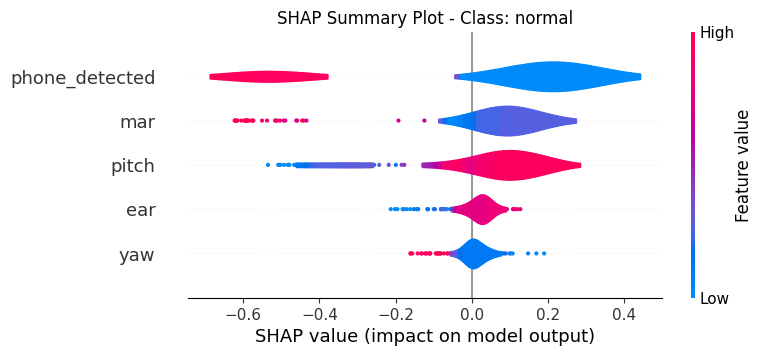

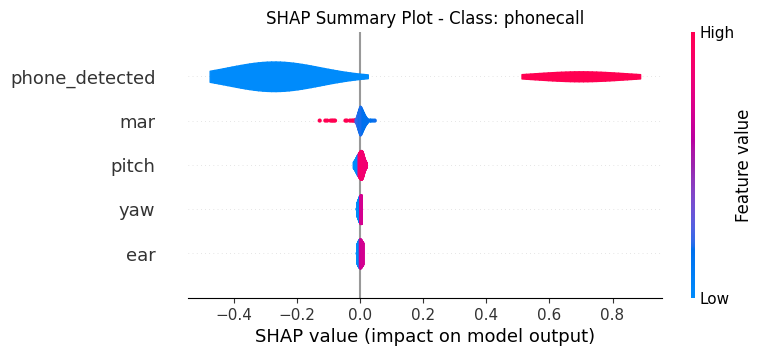

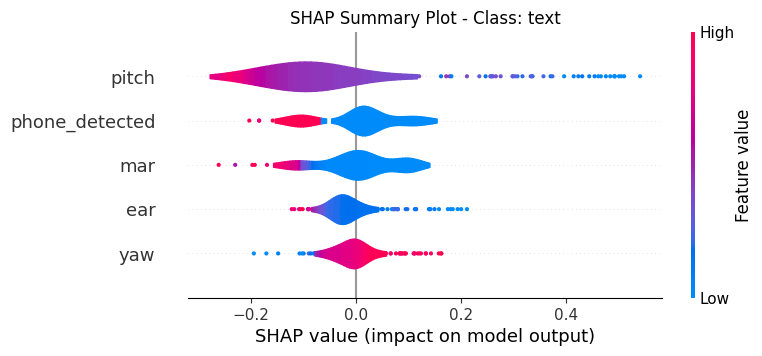

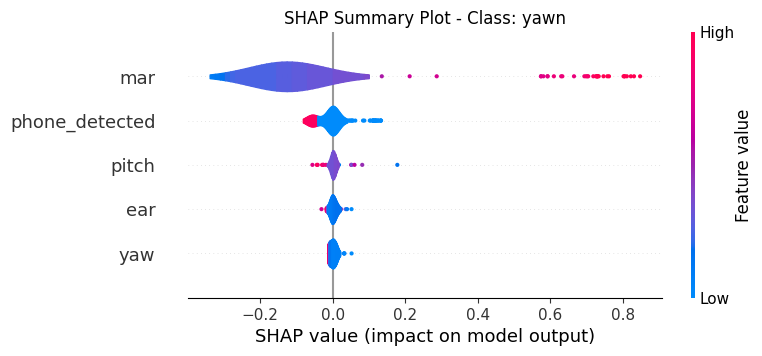

In [29]:
# SHAP summary plot
for class_idx in range(shap_vals.shape[2]):  # num_classes
    plt.figure()
    shap.summary_plot(
        shap_vals[:, :, class_idx],
        X_balanced,
        feature_names=cfg.features,
        plot_type="violin",
        show=False
    )
    plt.title(f"SHAP Summary Plot - Class: {cfg.labels[class_idx]}")


Class name : normal, number of samples : 53


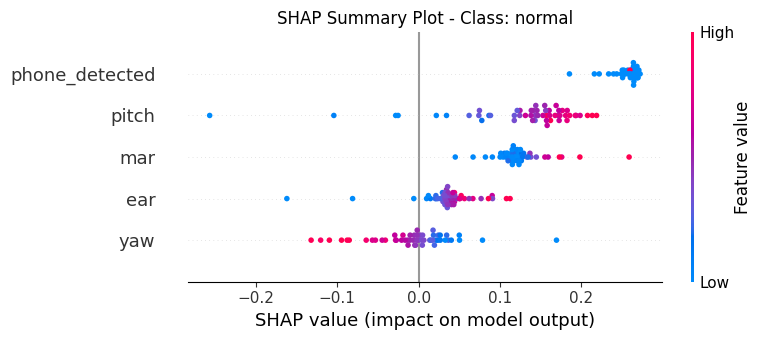

Class name : phonecall, number of samples : 53


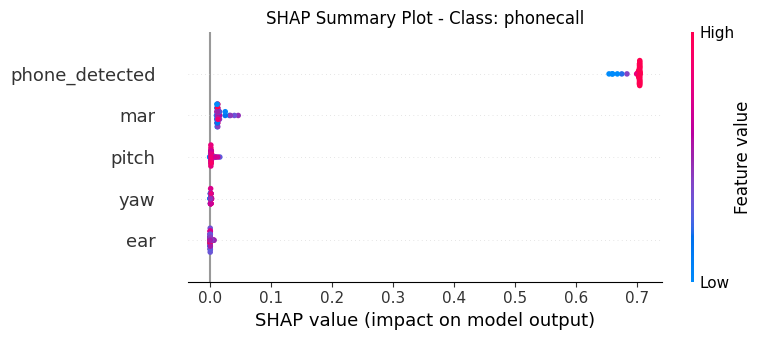

Class name : text, number of samples : 53


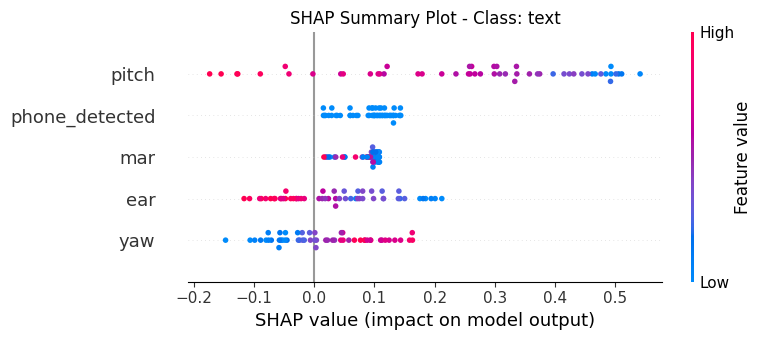

Class name : yawn, number of samples : 53


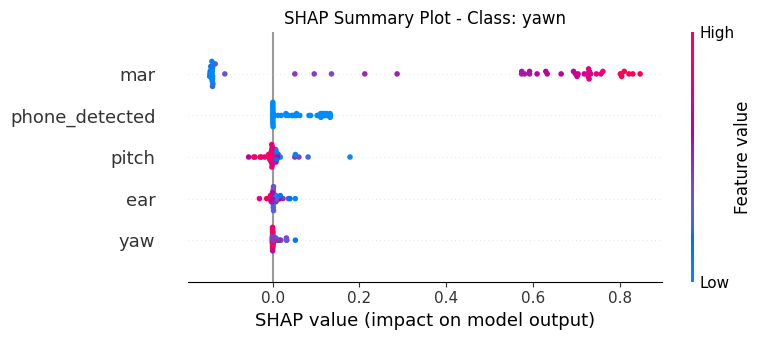

In [31]:
# 클래스별 데이터
for i in range(4):
    # 클래스 i에 해당하는 샘플 인덱스만 필터링
    idx = (y_balanced == i)

    # 해당 클래스 샘플의 shap값과 입력 데이터 필터링
    shap_vals_i = shap_vals[idx, :, i]  # (샘플 수_i, 피처 수)
    X_test_i = X_balanced[idx, :]   # (샘플 수_i, 피처 수)

    if shap_vals_i.shape[0] == 0:
        print(f"Class {cfg.labels[i]} has no samples in y_true, skipping plot.")
        continue

    print(f'Class name : {cfg.labels[i]}, number of samples : {shap_vals_i.shape[0]}')
    plt.figure()
    shap.summary_plot(
        shap_vals_i,
        X_test_i,
        feature_names=cfg.features,
        show=False
    )
    plt.title(f"SHAP Summary Plot - Class: {cfg.labels[i]}")
    plt.tight_layout()
    plt.show()


'''
output_names를 cfg.labels로 지정했기 때문에 이 순서와 shap_vals의 클래스 차원 순서가 동일
summary plot에 들어가는 feature matrix와 feature_names가 같은 순서와 개수를 가지므로, 그래프 축 라벨도 정확히 매칭\

가로축 : shap값. 각 피쳐가 클래스의 '예측'에 얼마나 기여했는지 보여줌(실제값 아님). 0값을 기준으로 양수면 가능성을 예측을 올려주고 음수면 낮춤
세로축 : 각 피쳐. 중요도가 높은 순서대로 내림차순 배치됨
점 : 하나의 샘플에 대한 각 피쳐의 shap값. 하나의 샘플은 모든 피쳐축에 점을 하나씩 찍는다
점의 색상 : 해당 피쳐에 대한 실제값. 실제값은 실제 피쳐들의 데이터를 말한다. 파란색이면 낮고, 빨간색이면 크다

shap 패턴 해석 방법
1. 특정 피쳐가 한쪽 방향으로만 분포됨 : 해당 피쳐가 이 클래스를 예측하는데 크게 기여
2. 점 색상 구분이 뚜렷함 : 빨간색과 파란색이 오른쪽 혹은 왼쪽으로 명확히 구분되어 분포됨
3. 클러스터의 구분이 뚜렷함 : 점들이 명확하게 분리되어 있으면 해당 피쳐의 영향력 강함
'''

## 추가 eda

### SHAP 값 분포 요약 통계 구하기

'''
mean_abs_shap가 높을수록 summary plot의 상위에 나온다
'''

In [32]:
'''
shap_array = shap_vals.values  # numpy array로 변환됨
feature_names = cfg.features  # ['pitch', 'mar', 'phone_detected', 'ear', 'yaw']

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [33]:
summaries = {}  # 클래스별 요약 통계 저장용 딕셔너리

for i, label in enumerate(cfg.labels):
    # 실제 클래스가 i인 샘플의 인덱스 추출
    idx = (y_balanced == i)

    # 해당 샘플이 하나도 없으면 건너뜀
    if idx.sum() == 0:
        print(f"Class {label} has no samples in y_true, skipping stats.")
        continue

    # 해당 클래스의 SHAP 값만 선택
    shap_df = pd.DataFrame(shap_vals[idx, :, i], columns=cfg.features)  # (샘플 수_i, 피처 수)

    # 통계 요약 계산
    summaries[label] = pd.DataFrame({
        "mean_abs_shap": shap_df.abs().mean(),
        "std_shap": shap_df.std(),
        "max_shap": shap_df.max(),
        "min_shap": shap_df.min(),
        'sample_count' : len(shap_df)
    }).sort_values("mean_abs_shap", ascending=False)

### 변수 간 중요도 차이 통계값 비교

In [34]:
for i in cfg.labels:
    df = summaries[i]
    df["rank_diff_from_top"] = df["mean_abs_shap"].iloc[0] - df['mean_abs_shap']
    summaries[i] = df

In [35]:
for i in cfg.labels:
    print(f"=== SHAP Summary for '{i}' class ===")
    print(summaries[i])

=== SHAP Summary for 'normal' class ===
                mean_abs_shap  std_shap  max_shap  min_shap  sample_count  \
phone_detected       0.258213  0.015378  0.272233  0.185360            53   
pitch                0.142067  0.082855  0.218716 -0.256871            53   
mar                  0.123261  0.030482  0.258716  0.045029            53   
ear                  0.045682  0.039695  0.112432 -0.161967            53   
yaw                  0.034793  0.050657  0.169428 -0.132161            53   

                rank_diff_from_top  
phone_detected            0.000000  
pitch                     0.116146  
mar                       0.134952  
ear                       0.212531  
yaw                       0.223419  
=== SHAP Summary for 'phonecall' class ===
                mean_abs_shap  std_shap  max_shap  min_shap  sample_count  \
phone_detected       0.698884  0.012379  0.704436  0.653597            53   
mar                  0.015316  0.007247  0.046425  0.010875            53   
p

### 상위 피쳐들의 feature value와 SHAP value 관계 분석

In [40]:
def plot_shap_feature_scatter(class_index):
    """
    특정 클래스 샘플만 필터링하여, mean_abs_shap 기준 상위 feature부터 순서대로
    각 feature value와 SHAP value의 관계를 산점도로 표현하고 mean_abs_shap 값 출력
    """
    label = cfg.labels[class_index]
    idx = (y_balanced == class_index)

    if idx.sum() == 0:
        print(f"[{label}] 클래스에 해당하는 샘플이 없습니다. 시각화를 건너뜁니다.")
        return

    # 해당 클래스의 SHAP 값과 feature 값 필터링
    shap_vals_class = shap_vals[idx, :, class_index]  # (샘플 수_i, 피처 수)
    X_vals = X_balanced[idx, :]              # (샘플 수_i, 피처 수)

    # DataFrame 변환
    shap_df = pd.DataFrame(shap_vals_class, columns=cfg.features)
    X_df = pd.DataFrame(X_vals, columns=cfg.features)

    # summary에서 해당 클래스의 상위 feature 순서 가져오기
    summary = summaries[label]
    top_features = summary.index.tolist()  # mean_abs_shap 기준 정렬됨

    # 피처별 산점도
    for feat in top_features:
        mean_abs_val = summary.loc[feat, "mean_abs_shap"]
        print(f"[{label}] Feature: {feat}, mean_abs_shap = {mean_abs_val:.2f}, number of sample = {len(shap_df)}")

        plt.figure(figsize=(5, 4))
        sns.scatterplot(x=X_df[feat], y=shap_df[feat], alpha=0.7)
        plt.title(f"[{label}] {feat} vs SHAP Value\n(mean_abs_shap={mean_abs_val:.2f})")
        plt.xlabel("Feature Value")
        plt.ylabel("SHAP Value")
        plt.axhline(0, color='gray', linestyle='--', linewidth=1)
        plt.tight_layout()
        plt.show()

[normal] Feature: phone_detected, mean_abs_shap = 0.26, number of sample = 53


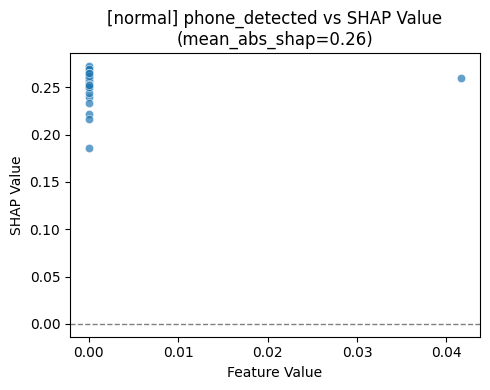

[normal] Feature: pitch, mean_abs_shap = 0.14, number of sample = 53


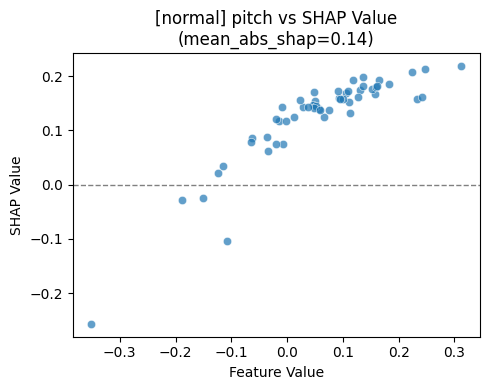

[normal] Feature: mar, mean_abs_shap = 0.12, number of sample = 53


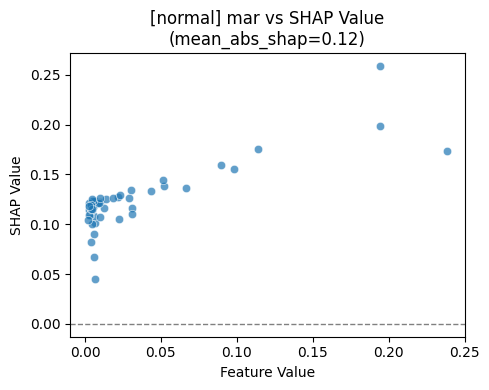

[normal] Feature: ear, mean_abs_shap = 0.05, number of sample = 53


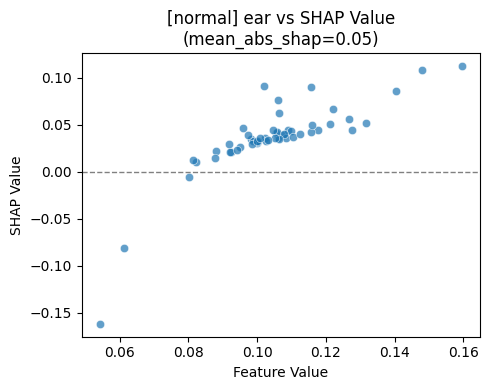

[normal] Feature: yaw, mean_abs_shap = 0.03, number of sample = 53


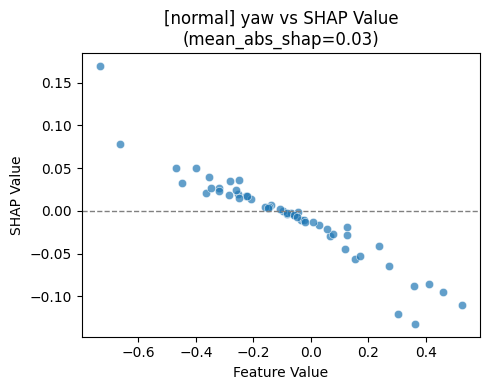

In [41]:
plot_shap_feature_scatter(class_index=0)

[phonecall] Feature: phone_detected, mean_abs_shap = 0.70, number of sample = 53


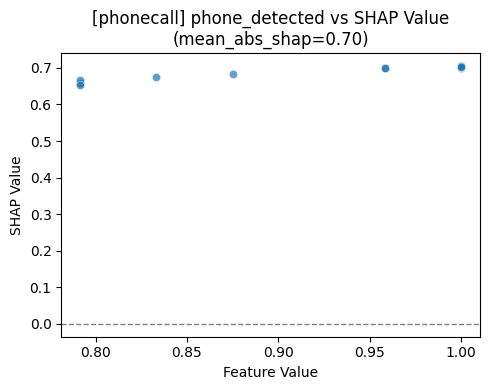

[phonecall] Feature: mar, mean_abs_shap = 0.02, number of sample = 53


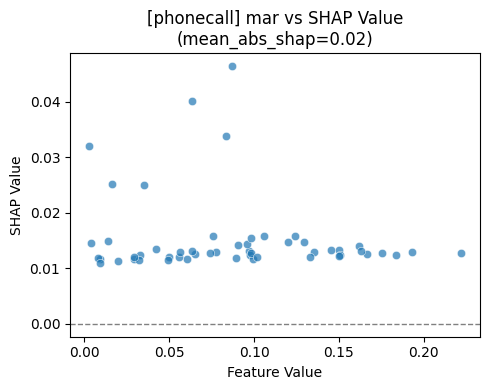

[phonecall] Feature: pitch, mean_abs_shap = 0.00, number of sample = 53


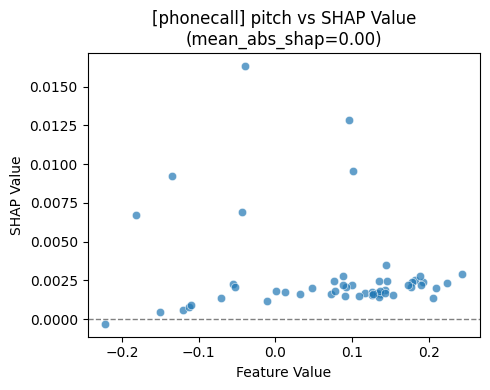

[phonecall] Feature: yaw, mean_abs_shap = 0.00, number of sample = 53


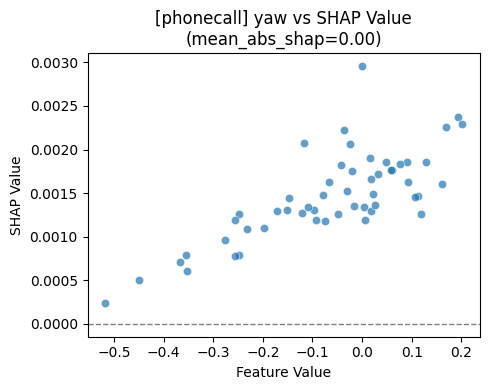

[phonecall] Feature: ear, mean_abs_shap = 0.00, number of sample = 53


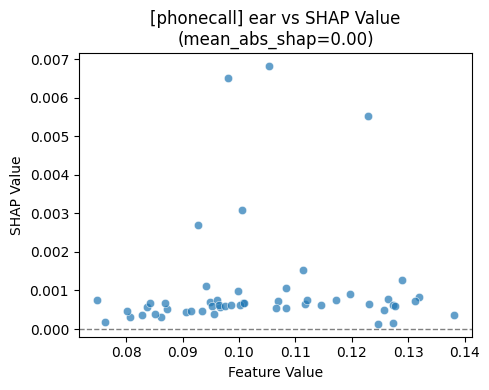

In [42]:
plot_shap_feature_scatter(class_index=1)

[text] Feature: pitch, mean_abs_shap = 0.29, number of sample = 53


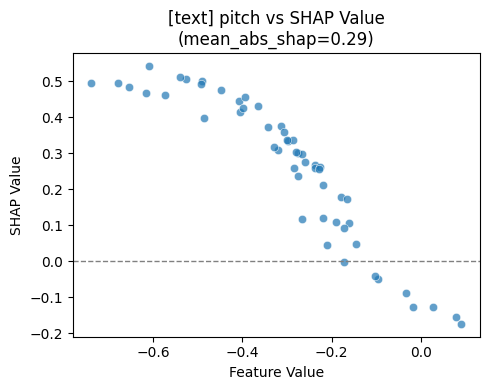

[text] Feature: phone_detected, mean_abs_shap = 0.09, number of sample = 53


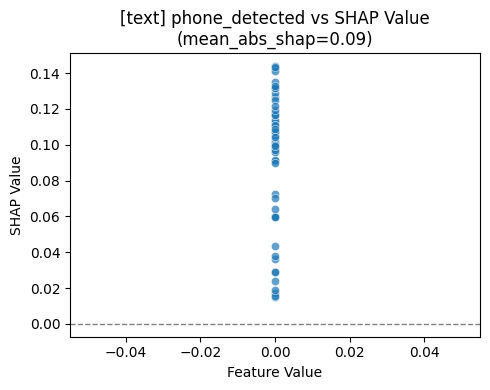

[text] Feature: mar, mean_abs_shap = 0.09, number of sample = 53


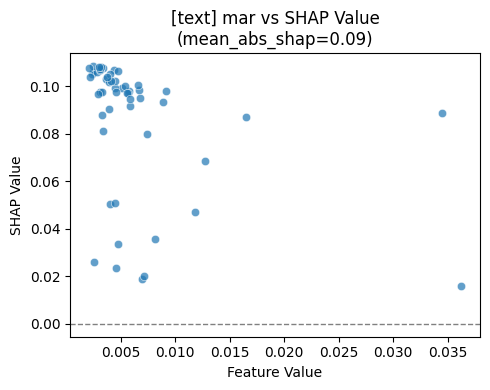

[text] Feature: ear, mean_abs_shap = 0.08, number of sample = 53


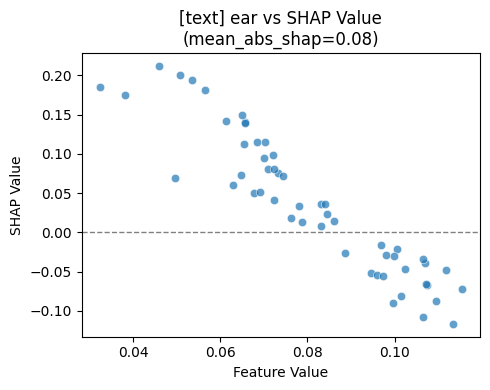

[text] Feature: yaw, mean_abs_shap = 0.07, number of sample = 53


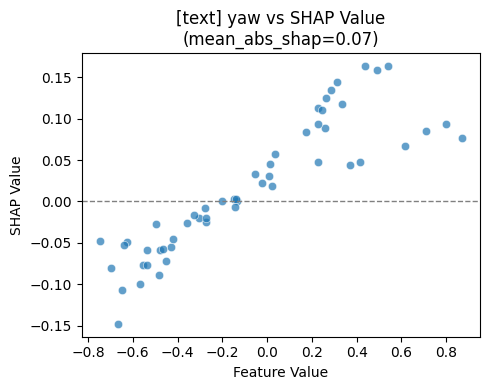

In [43]:
plot_shap_feature_scatter(class_index=2)

[yawn] Feature: mar, mean_abs_shap = 0.46, number of sample = 53


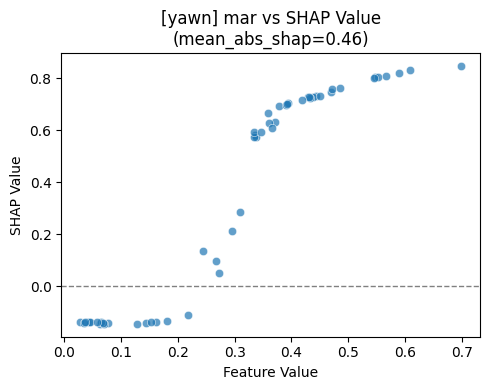

[yawn] Feature: phone_detected, mean_abs_shap = 0.06, number of sample = 53


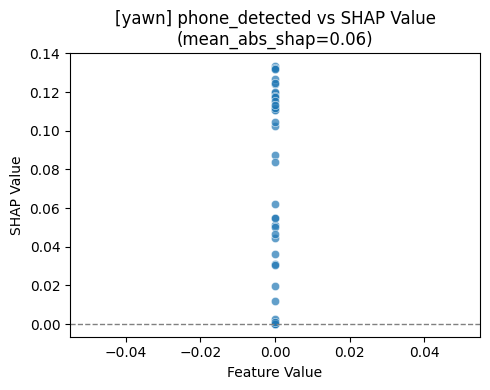

[yawn] Feature: pitch, mean_abs_shap = 0.02, number of sample = 53


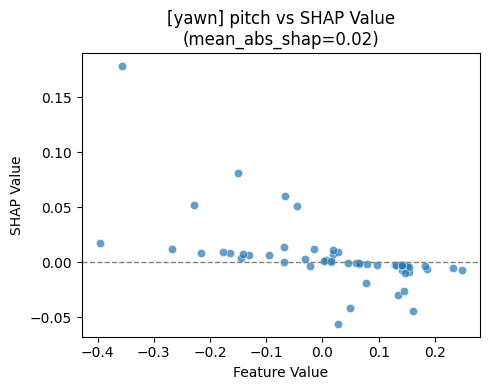

[yawn] Feature: ear, mean_abs_shap = 0.01, number of sample = 53


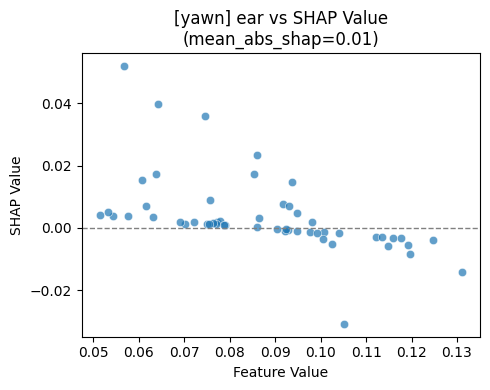

[yawn] Feature: yaw, mean_abs_shap = 0.01, number of sample = 53


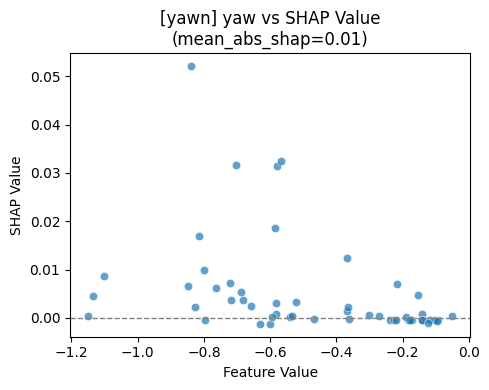

In [44]:
plot_shap_feature_scatter(class_index=3)

'''
X축: yaw의 feature 값

Y축: yaw가 text 클래스에 대해 갖는 SHAP 값

즉, 각 샘플의 yaw 값이 text 클래스 예측에 얼마나 영향을 줬는지 보여줌

shap값이 0보다 크거나 작으면 해당 클래스일 확률을 높이거나 낮추는데 0이면 아무런 영향없음

해당 클래스를 설명하는데 유용한 피쳐라고 할 수 있는 근거들

1. SHAP 값의 범위가 넓은가? -> 넓을수록 영향력이 크다

2. 산점도의 패턴이 존재하는가? -> shap값 변화의 패턴이 존재

3. 극단적인 피쳐 값에서 shap값도 극단적인가? -> 특정 값 구간에서 shap값 변화가 크면 영향이 크다는 의미

4. shap값의 분산이 큰가? -> 비슷한 피쳐 값에서 shap값 변화가 크다면 그 피쳐가 다양한 방식으로 영향을 미친다는 것

5. 데이터 밀도가 높을 때 shap가 일관적인가? -> 샘플수가 많은 영역에서 값의 방향이 동일하다면 신뢰도가 높다

 중요도가 높고 경향성이 불명확한 피쳐보다 중요도는 더 낮지만 경향성이 뚜렷한 피쳐를 더 중요한 것으로 간주해도 타당하다
'''